In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd
import scanpy as sc
from PIL import Image # Converting image
import os # for parquet file
from pathlib import Path

# from tifffile import imread, imwrite
# from csbdeep.utils import normalize
# from stardist.models import StarDist2D
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as MplPath 
%matplotlib widget


In [23]:
SEGMENTATION_PATH = Path("/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
                         "dietary_droject/data/cell_segmentation")

sample_id = "F07834"

adata_path = SEGMENTATION_PATH / sample_id / f"{sample_id}_grouped_filtered_adata.h5ad"
gdf_file = SEGMENTATION_PATH / sample_id / f"{sample_id}_gdf.gpkg"

# Load adata
ST_sample = sc.read_h5ad(adata_path)
# load your polygons
geo_file = gpd.read_file(gdf_file)

In [21]:
type(gdf)

geopandas.geodataframe.GeoDataFrame

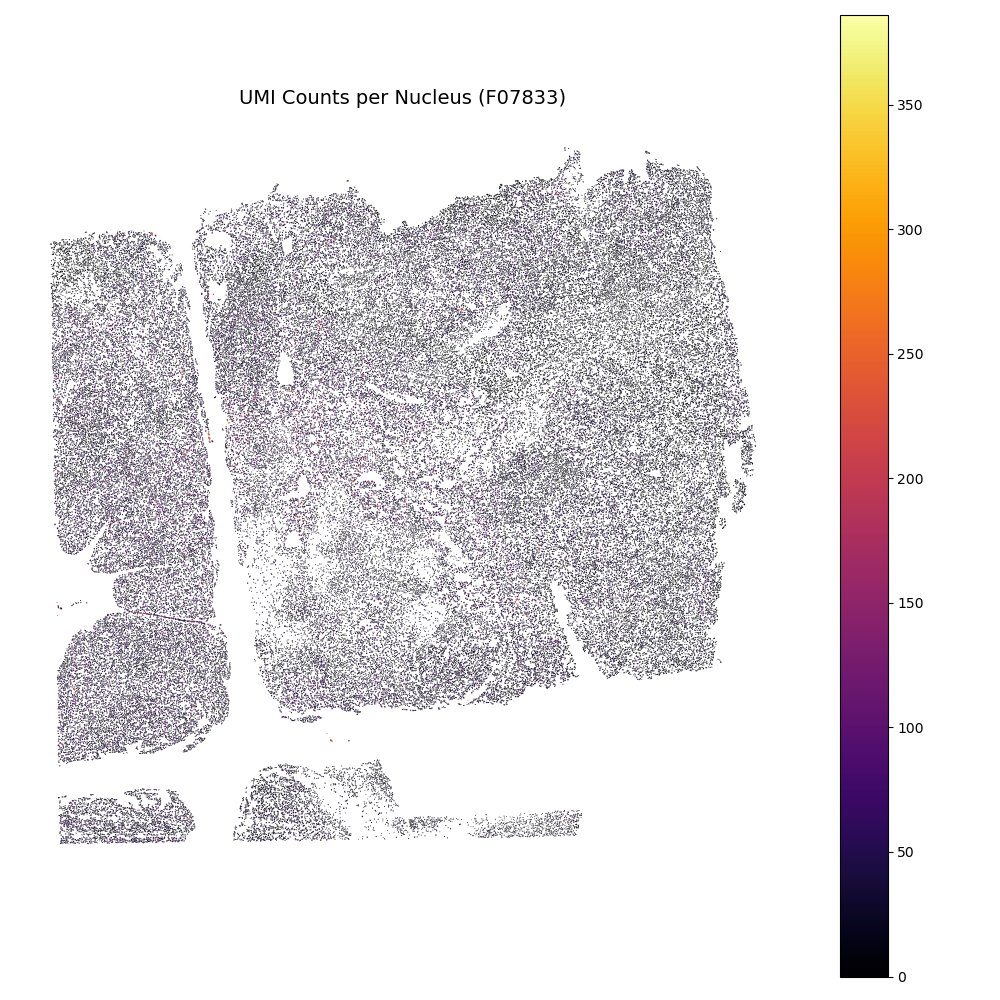

In [24]:
# 1. Compute total UMI counts per nucleus from the AnnData object
total_umis = ST_sample.X.sum(axis=1).A1  # flatten sparse matrix
ST_sample.obs['total_umis'] = total_umis

# 2. Merge with geometry data from GeoPackage
gdf_umi = geo_file.merge(ST_sample.obs[['total_umis']], left_on='id', right_index=True)

# 3. Plot polygons colored by total UMI count
fig, ax = plt.subplots(figsize=(10, 10))
gdf_umi.plot(column='total_umis',
             cmap='inferno',
             legend=True,
             linewidth=0.1,
             edgecolor='black',
             ax=ax)

ax.set_title("UMI Counts per Nucleus (F07833)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [7]:
# compute centroids & assign section
centroids = gdf.geometry.centroid
gdf['cx'] = centroids.x
gdf['cy'] = centroids.y
gdf['section'] = None

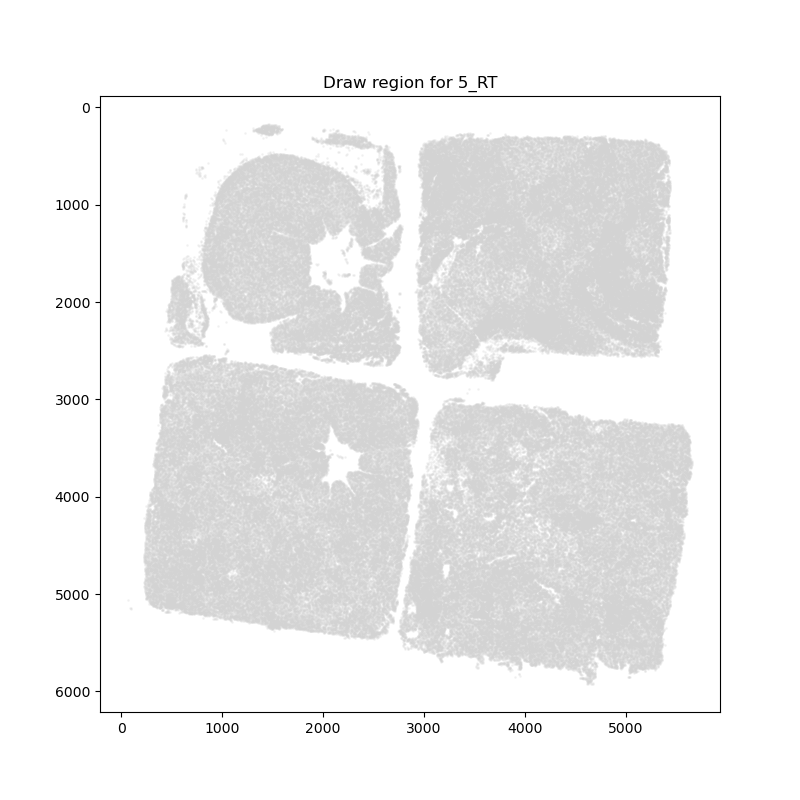

In [8]:
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

# 1. your predefined labels, in the order you’ll draw them:
tissue_labels = ["5_RT", "33_KDRT", "9_KDRT", "28_LFRT"]

# 2. prepare your GeoDataFrame
gdf['region'] = None            # spot-level region label
gdf['cx'] = gdf.geometry.centroid.x
gdf['cy'] = gdf.geometry.centroid.y

# 3. set up counters & handles
counter = [0]                   # will go 0 → 1 → 2 → 3
overlay = []                    # to keep each scatter layer

# 4. make the figure
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(gdf['cx'], gdf['cy'], s=1, alpha=0.2, color='lightgray')
ax.invert_yaxis()
ax.set_title(f"Draw region for {tissue_labels[0]}")

def onselect(verts):
    i = counter[0]
    label = tissue_labels[i]
    
    # build mask of points inside the lasso
    path = MplPath(verts)
    pts = gdf[['cx','cy']].values
    mask = path.contains_points(pts)
    
    # assign that region label
    gdf.loc[mask, 'region'] = label
    print(f"→ {mask.sum()} cells labeled “{label}”")
    
    # plot those selected cells in a new color
    color = ["red","blue","green","orange"][i]
    h = ax.scatter(
        gdf.loc[mask,'cx'],
        gdf.loc[mask,'cy'],
        s=8, color=color, alpha=0.8,
        label=label
    )
    overlay.append(h)
    
    # advance counter
    counter[0] += 1
    if counter[0] < len(tissue_labels):
        ax.set_title(f"Now draw region for {tissue_labels[counter[0]]}")
    else:
        ax.set_title("Done! Closing selector…")
        lasso.disconnect_events()   # stop listening
        plt.close(fig)             # close the window
    
    ax.legend(handles=overlay, loc='best')
    fig.canvas.draw_idle()

lasso = LassoSelector(ax, onselect)
plt.show()

In [ ]:
# 1) assign the TMA/sample ID to every spot
gdf['sample_id'] = sample_id

# 2) pull out the condition (the letters after “_”)
gdf['condition'] = gdf['region'].str.split('_').str[1]

In [ ]:
import scanpy as sc

# load your annotated GeoDataFrame
# (it already has 'id' matching ST_sample.obs.index)
meta = gdf.set_index('id')[['region','sample_id','condition','cx','cy','geometry']]

# join into the .obs and store the geometry in .obsm
ST_sample.obs = ST_sample.obs.join(meta[['region','sample_id','condition','cx','cy']])

# store the Shapely geometry in an AnnData layer (obsm)
# so it survives concatenation, plots, etc.
ST_sample.obsm['geometry'] = meta['geometry']

In [ ]:
outpath = segmentation_path / sample_id / f"{sample_id}_annotated_adata.h5ad"
ST_sample.write(outpath)
print("Wrote:", outpath)

In [17]:
#COMbine later

import anndata as ad

samples = ["F07833","F07834","F07835","F07836"]
adatas = [sc.read_h5ad(f"{s}_annotated_adata.h5ad") for s in samples]

# concat along observations, keep the geometry in obsm
combined = ad.concat(adatas, join="outer", label="sample_id", keys=samples)
combined.write("combined_TMA_all.h5ad")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'F07833_annotated_adata.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)